In [2]:
# Data Processing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime

# Modelling
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay, classification_report
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.model_selection import KFold
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib
from joblib import load
import os

# Tree Visualisation
from sklearn.tree import export_graphviz
from IPython.display import Image
import graphviz
import plotly.graph_objects as go

# Train the model

Total training samples: 2242
Total validation samples: 962

Class distribution in training set:
Emotion
2    399
1    339
0    326
5    311
3    309
6    292
4    266
Name: count, dtype: int64

Class distribution in validation set:
Emotion
2    176
0    157
6    146
1    140
5    115
3    114
4    114
Name: count, dtype: int64

Classification Report for Training Set (K-Fold Cumulative):
              precision    recall  f1-score   support

       anger       0.98      0.91      0.94       326
       happy       0.97      0.91      0.94       339
         sad       0.81      0.98      0.88       399
        fear       0.98      0.89      0.93       309
     disgust       0.99      1.00      0.99       266
    surprise       0.99      0.97      0.98       311
       shame       0.99      0.97      0.98       292

    accuracy                           0.94      2242
   macro avg       0.96      0.94      0.95      2242
weighted avg       0.95      0.94      0.95      2242



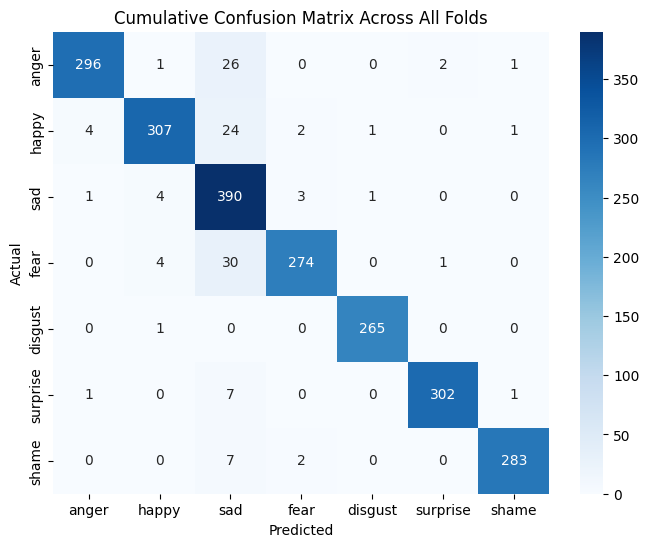

Validation accuracy: 0.9708939708939709

Classification Report for Validation Set:
              precision    recall  f1-score   support

       anger       0.99      0.91      0.95       157
       happy       0.99      0.99      0.99       140
         sad       0.90      0.99      0.94       176
        fear       0.99      0.94      0.96       114
     disgust       0.99      1.00      1.00       114
    surprise       0.99      1.00      1.00       115
       shame       0.99      0.98      0.99       146

    accuracy                           0.97       962
   macro avg       0.98      0.97      0.97       962
weighted avg       0.97      0.97      0.97       962



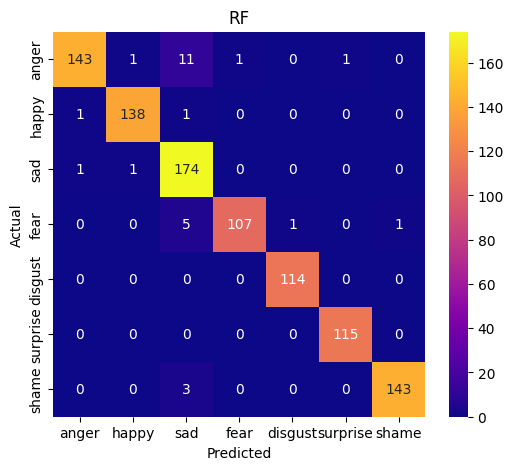

In [5]:
train_df = pd.read_csv('training_set.csv', encoding='utf-8', encoding_errors='replace')
valid_df = pd.read_csv('validation_set.csv', encoding='utf-8', encoding_errors='replace')

label_mapping = {
    'anger': 0,
    'happy': 1,
    'sad': 2,
    'fear': 3,
    'disgust': 4,
    'surprise': 5,
    'shame': 6
}

train_df = train_df[train_df['Emotion'].isin(label_mapping.keys())]
valid_df = valid_df[valid_df['Emotion'].isin(label_mapping.keys())]

X_train = train_df['Text']
y_train = train_df['Emotion'].map(label_mapping)
X_valid = valid_df['Text']
y_valid = valid_df['Emotion'].map(label_mapping)

print(f"Total training samples: {len(train_df)}")
print(f"Total validation samples: {len(valid_df)}")
print("\nClass distribution in training set:")
print(y_train.value_counts())
print("\nClass distribution in validation set:")
print(y_valid.value_counts())

tfidf = TfidfVectorizer(stop_words='english')

X_train_tfidf = tfidf.fit_transform(X_train)
X_valid_tfidf = tfidf.transform(X_valid)

rfc = RandomForestClassifier(max_depth=26, min_samples_split=7, n_estimators=443)

kf = KFold(n_splits=7, shuffle=True, random_state=42)
cv_folds = []
all_folds = np.zeros((len(label_mapping), len(label_mapping)))
y_true_all = []
y_pred_all = []

for train_idx, test_idx in kf.split(X_train):
    X_train_fold, X_test_fold = X_train.iloc[train_idx], X_train.iloc[test_idx]
    y_train_fold, y_test_fold = y_train.iloc[train_idx], y_train.iloc[test_idx]

    X_train_tfidf_fold = tfidf.fit_transform(X_train_fold)
    X_test_tfidf_fold = tfidf.transform(X_test_fold)

    rfc.fit(X_train_tfidf_fold, y_train_fold)

    y_pred_fold = rfc.predict(X_test_tfidf_fold)
    
    accuracy = accuracy_score(y_test_fold, y_pred_fold)
    cv_folds.append(accuracy)
    
    cm = confusion_matrix(y_test_fold, y_pred_fold)
    all_folds += cm
    
    y_true_all.extend(y_test_fold)
    y_pred_all.extend(y_pred_fold)

print("\nClassification Report for Training Set (K-Fold Cumulative):")
print(classification_report(y_true_all, y_pred_all, target_names=label_mapping.keys()))

plt.figure(figsize=(8, 6))
sns.heatmap(all_folds, annot=True, fmt=".0f", cmap="Blues", 
            xticklabels=label_mapping.keys(), 
            yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Cumulative Confusion Matrix Across All Folds")
plt.show()

folds = [f"Fold {i+1}" for i in range(len(cv_folds))]

fig = go.Figure()
fig.add_trace(go.Scatter(
    x=folds,
    y=cv_folds,
    mode='lines+markers+text',
    text=[f"{acc:.4f}" for acc in cv_folds],  
    textposition="top center",
    marker=dict(size=10, color='blue', line=dict(width=2, color='black')),
    line=dict(width=3, color='royalblue'),
    name="Accuracy"
))

fig.update_layout(
    title="K-Fold Cross-Validation Accuracy",
    xaxis_title="Fold",
    yaxis_title="Accuracy",
    template="plotly_white",
    font=dict(size=14),
    xaxis=dict(showgrid=False),
    yaxis=dict(showgrid=True, gridcolor="lightgray"),
    hovermode="x unified"
)
fig.show()

rfc.fit(X_train_tfidf, y_train)

y_pred = rfc.predict(X_valid_tfidf)

accuracy = accuracy_score(y_valid, y_pred)
print(f"Validation accuracy: {accuracy}")

print("\nClassification Report for Validation Set:")
print(classification_report(y_valid, y_pred, target_names=label_mapping.keys()))

cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="plasma", 
            xticklabels=label_mapping.keys(), 
            yticklabels=label_mapping.keys())
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("RF")
plt.show()


# Hyperparameter estimator

In [ ]:
param_dist = {'n_estimators': randint(50,500),
              'max_depth': randint(1,20)}

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=5)

# Fit the random search object to the data
rand_search.fit(X_train_tfidf_fold, y_train)

# Save the model

In [ ]:
if not os.path.exists('models'):
    os.makedirs('models')

timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")

best_model, best_vectorizer = rfc, tfidf

model_filename = f'models/random_forest_emotion_classifier_{timestamp}.joblib'
joblib.dump(best_model, model_filename)

vectorizer_filename = f'models/tfidf_vectorizer_{timestamp}.joblib'
joblib.dump(best_vectorizer, vectorizer_filename)

# Load the model

In [ ]:
model = joblib.load(model_filename)
vectorizer = joblib.load(vectorizer_filename)

text = "What a shame"
text_tfidf = vectorizer.transform([text])
prediction = model.predict(text_tfidf)
print(f"Predicted emotion: {prediction[0]}")

# ROC Curve

In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
from itertools import cycle

y_valid_bin = label_binarize(y_valid, classes=list(label_mapping.values()))
n_classes = y_valid_bin.shape[1]

y_score = rfc.predict_proba(X_valid_tfidf)

plt.figure(figsize=(8, 6))
colors = cycle(['blue', 'red', 'green', 'purple', 'orange', 'brown', 'pink'])

for i, color in zip(range(n_classes), colors):
    fpr, tpr, _ = roc_curve(y_valid_bin[:, i], y_score[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color=color, lw=2, label=f"{list(label_mapping.keys())[i]} (AUC = {roc_auc:.2f})")

plt.plot([0, 1], [0, 1], 'k--', lw=2) 
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve for Multi-Class Emotion Classification')
plt.legend(loc="lower right")
plt.show()
